# 1. Library Imports & Environment Setup
**Objective:** Load all necessary Python tools required for data manipulation, visualization, and machine learning.

* **`pandas`:** Used for loading and manipulating the dataset (tables).
* **`seaborn` / `matplotlib`:** Used for creating graphs and visualizations.
* **`sklearn`:** Contains the machine learning models (Random Forest) and evaluation metrics.

> **Note:** `%matplotlib inline` is a special command that ensures graphs appear directly in the notebook.

In [20]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn import metrics
import joblib 

# Import the models we want to compare
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor

# Ensure graphs appear inside the notebook
%matplotlib inline

## 2. Loading the Dataset
**Objective:** Read the raw data file and perform initial safety checks.

* **Action:** Loads `googleplaystore.csv` into a Pandas DataFrame.
* **Safety Check:** Instantly removes a specific known corrupt row (Category '1.9') to prevent system errors.
* **Output:** Prints the dataset dimensions (rows/columns) and displays the first few records to verify successful loading.

In [21]:
# Load the dataset
df = pd.read_csv('googleplaystore.csv')

# Drop specific corrupt row known in this dataset (Category = '1.9') if it exists
df = df[df['Category'] != '1.9']

print(f"Dataset Shape: {df.shape}")
df.head(3)

Dataset Shape: (10840, 13)


,App,Category,Rating,Reviews,Size,Installs,Type,Price,Content Rating,Genres,Last Updated,Current Ver,Android Ver
0,Photo Editor & Candy Camera & Grid & ScrapBook,ART_AND_DESIGN,4.1,159,19M,"10,000+",Free,0,Everyone,Art & Design,"January 7, 2018",1.0.0,4.0.3 and up
1,Coloring book moana,ART_AND_DESIGN,3.9,967,14M,"500,000+",Free,0,Everyone,Art & Design;Pretend Play,"January 15, 2018",2.0.0,4.0.3 and up
2,"U Launcher Lite – FREE Live Cool Themes, Hide ...",ART_AND_DESIGN,4.7,87510,8.7M,"5,000,000+",Free,0,Everyone,Art & Design,"August 1, 2018",1.2.4,4.0.3 and up


## 3. Data Cleaning & Pre-processing
**Objective:** Clean messy human-entered data so the AI can process it mathematically.

**Key Steps Performed:**
1.  **Rating:** Fills missing values with the **Median** rating to handle gaps without skewing the average.
2.  **Reviews:** Converts text strings into usable numbers.
3.  **Size:** Standardizes "M" (Megabytes) and "k" (Kilobytes) into a single numeric format (bytes).
4.  **Installs & Price:** Removes non-numeric symbols (`+`, `,`, `$`) to convert them into pure integers/floats.
5.  **Cleanup:** Drops duplicate rows and columns irrelevant to prediction (e.g., App Name, Version).

In [22]:
# 1. Cleaning 'Rating' (Target Variable) -> Impute with median
df['Rating'] = df['Rating'].fillna(df['Rating'].median())

# 2. Cleaning 'Reviews' -> Convert to numeric
df['Reviews'] = pd.to_numeric(df['Reviews'], errors='coerce')

# 3. Cleaning 'Size' -> Handle 'M', 'k', and 'Varies'
def clean_size(size):
    if 'M' in str(size):
        return float(str(size).replace('M', '')) * 1_000_000
    elif 'k' in str(size):
        return float(str(size).replace('k', '')) * 1_000
    elif 'Varies with device' in str(size):
        return np.nan
    else:
        return np.nan

df['Size'] = df['Size'].apply(clean_size)
df['Size'] = df['Size'].fillna(df['Size'].mean())

# 4. Cleaning 'Installs' -> Remove '+' and ','
df['Installs'] = df['Installs'].astype(str).str.replace('+', '').str.replace(',', '')
df['Installs'] = pd.to_numeric(df['Installs'], errors='coerce')

# 5. Cleaning 'Price' -> Remove '$'
df['Price'] = df['Price'].astype(str).str.replace('$', '')
df['Price'] = pd.to_numeric(df['Price'], errors='coerce')

# 6. Cleaning Categorical Columns
df['Type'] = df['Type'].fillna('Free')
df['Content Rating'] = df['Content Rating'].fillna('Everyone')

# Drop duplicates and unuseful columns
df.drop_duplicates(inplace=True)
df.drop(['App', 'Last Updated', 'Current Ver', 'Android Ver', 'Genres'], axis=1, inplace=True)

print("Data Cleaning Completed.")
df.info()

Data Cleaning Completed.
<class 'pandas.core.frame.DataFrame'>
Index: 10357 entries, 0 to 10840
Data columns (total 8 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Category        10357 non-null  object 
 1   Rating          10357 non-null  float64
 2   Reviews         10357 non-null  int64  
 3   Size            10357 non-null  float64
 4   Installs        10357 non-null  int64  
 5   Type            10357 non-null  object 
 6   Price           10357 non-null  float64
 7   Content Rating  10357 non-null  object 
dtypes: float64(3), int64(2), object(3)
memory usage: 728.2+ KB


## 4. Visualization: Target Variable Distribution
**Objective:** Visualize the spread of the App Ratings to understand the data balance.

* **Graph Type:** Histogram / KDE.
* **Insight:** The data is **Left-Skewed**, meaning most apps have high ratings (between 4.0 and 5.0).
* **Impact:** The model will likely be better at predicting high ratings than low ones, simply because it has more examples of high ratings to learn from.

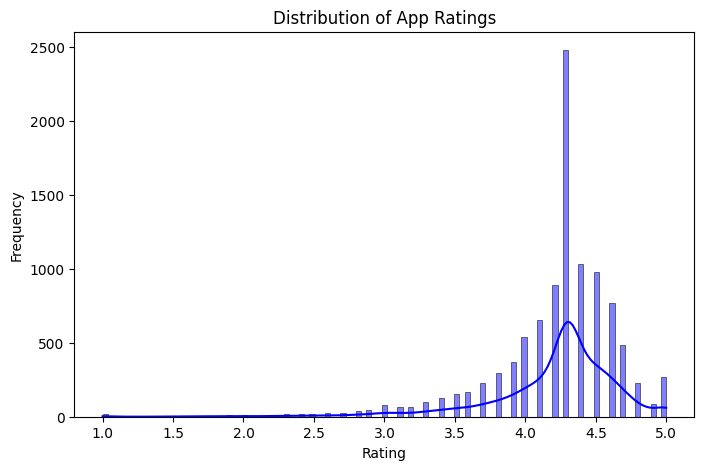

In [23]:
plt.figure(figsize=(8, 5))
sns.histplot(df['Rating'], kde=True, color='blue')
plt.title('Distribution of App Ratings')
plt.xlabel('Rating')
plt.ylabel('Frequency')
plt.show()

## 5. Visualization: Feature Correlation
**Objective:** Identify relationships between numerical features.

* **Graph Type:** Heatmap.
* **Metric:** Correlation Coefficient (from -1.0 to 1.0).
    * **1.0:** Perfect positive relationship (both increase together).
    * **-1.0:** Perfect negative relationship (one increases, other decreases).
    * **0:** No relationship.
* **Goal:** To see which features (like Reviews or Installs) might strongly predict the Rating.

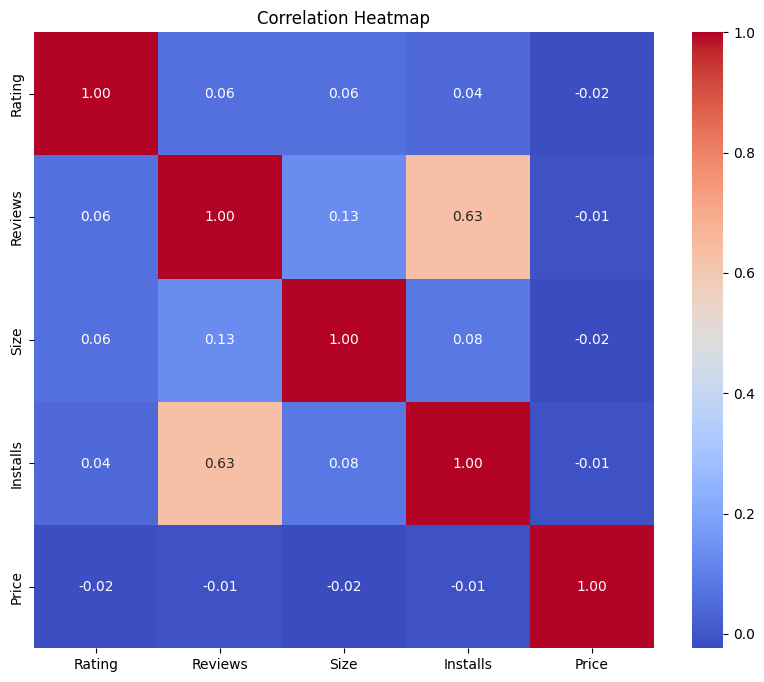

In [24]:
plt.figure(figsize=(10, 8))
# Select only numeric columns for correlation
numeric_df = df.select_dtypes(include=[np.number])
sns.heatmap(numeric_df.corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Heatmap')
plt.show()

## 6. Feature Engineering: Encoding
**Objective:** Convert text-based categories into a machine-readable format.

* **Technique:** **One-Hot Encoding**.
* **Process:** Splits a column like `Category` into multiple binary columns (e.g., `Category_GAME`, `Category_TOOLS`).
* **Why?** Machine Learning models cannot perform math on words like "Family" or "Business"; they only understand binary numbers (0s and 1s).

In [25]:
# Convert Categorical columns to Numeric using One-Hot Encoding
df = pd.get_dummies(df, columns=['Category', 'Content Rating', 'Type'], drop_first=True)

print(f"New Data Shape after Encoding: {df.shape}")
df.head(2)

New Data Shape after Encoding: (10357, 43)


,Rating,Reviews,Size,Installs,Price,Category_AUTO_AND_VEHICLES,Category_BEAUTY,Category_BOOKS_AND_REFERENCE,Category_BUSINESS,Category_COMICS,...,Category_TOOLS,Category_TRAVEL_AND_LOCAL,Category_VIDEO_PLAYERS,Category_WEATHER,Content Rating_Everyone,Content Rating_Everyone 10+,Content Rating_Mature 17+,Content Rating_Teen,Content Rating_Unrated,Type_Paid
0,4.1,159,19000000.0,10000,0.0,False,False,False,False,False,...,False,False,False,False,True,False,False,False,False,False
1,3.9,967,14000000.0,500000,0.0,False,False,False,False,False,...,False,False,False,False,True,False,False,False,False,False


## 8. Feature Scaling (Normalization)
**Objective:** Adjust all numbers to a standard scale (0 to 1).

* **Technique:** MinMax Scaling.
* **Reasoning:**
    * *Installs* can range into the millions.
    * *Rating* is only 1 to 5.
    * Without scaling, the model might biasedly treat "Installs" as the most important feature simply because the numbers are larger. Scaling ensures all features compete fairly.

In [26]:
# Separate Features (X) and Target (y)
X = df.drop('Rating', axis=1)
y = df['Rating']

# Scale features to a range of 0-1
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

# Turn it back into a DataFrame for easier handling
X = pd.DataFrame(X_scaled, columns=X.columns)
print("Data Normalized.")

Data Normalized.


## 9. Data Splitting
**Objective:** Separate data into learning material and testing material.

* **Training Set (80%):** Used to teach the model patterns.
* **Testing Set (20%):** Kept hidden from the model to evaluate its performance later.
* **Why?** This prevents "overfitting" (cheating), ensuring the model works on new data it has never seen before.


In [27]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"Training Samples: {X_train.shape[0]}")
print(f"Testing Samples: {X_test.shape[0]}")

Training Samples: 8285
Testing Samples: 2072


## Step 10: Models Training
**Objective:** Train multiple algorithms to see which one performs best.

**Models Selected:**
1.  **Linear Regression:** A simple baseline model that draws a straight line through the data.
2.  **Decision Tree:** A model that splits data into branches (like a flowchart).
3.  **Random Forest:** An "ensemble" of many Decision Trees working together.

In [28]:
# Initialize a dictionary of models
models = {
    "Linear Regression": LinearRegression(),
    "Decision Tree": DecisionTreeRegressor(random_state=42),
    "Random Forest": RandomForestRegressor(n_estimators=100, random_state=42)
}

# Train (fit) each model
print("Training Models...")
for name, model in models.items():
    model.fit(X_train, y_train)
    print(f" -> {name} trained.")

print("All models trained successfully!")

Training Models...
 -> Linear Regression trained.
 -> Decision Tree trained.
 -> Random Forest trained.
All models trained successfully!


## Step 11: Model Evaluation & Comparison
**Objective:** Test all models on the hidden test set and compare their accuracy.

**Metrics:**
* **MAE (Mean Absolute Error):** Lower is better.
* **R² Score:** Higher is better (Closer to 1.0).

We create a **Leaderboard** to identify the winner.

In [29]:
results = []

print("Model Performance Results:\n")

# Loop through models to get predictions and metrics
for name, model in models.items():
    y_pred = model.predict(X_test)
    
    # Calculate Metrics
    mae = metrics.mean_absolute_error(y_test, y_pred)
    mse = metrics.mean_squared_error(y_test, y_pred)
    r2 = metrics.r2_score(y_test, y_pred)
    
    # Save results to a list
    results.append({"Model": name, "MAE": mae, "MSE": mse, "R2 Score": r2})
    
    # Print individual result
    print(f"--- {name} ---")
    print(f"MAE: {mae:.4f} | R2 Score: {r2:.4f}\n")

# Convert results to a DataFrame for easy comparison
results_df = pd.DataFrame(results)

# Sort by R2 Score (Best to Worst)
results_df = results_df.sort_values(by="R2 Score", ascending=False)
print("\nFinal Leaderboard:")
print(results_df)

Model Performance Results:

--- Linear Regression ---
MAE: 0.3287 | R2 Score: 0.0209

--- Decision Tree ---
MAE: 0.3900 | R2 Score: -0.5770

--- Random Forest ---
MAE: 0.3116 | R2 Score: 0.0407


Final Leaderboard:
               Model       MAE       MSE  R2 Score
2      Random Forest  0.311607  0.239170  0.040711
0  Linear Regression  0.328700  0.244105  0.020917
1      Decision Tree  0.390001  0.393168 -0.576962


## Step 12: Results Visualization
**Objective:** Visually compare the models to pick a winner.

**Graphs:**
1.  **Bar Chart:** Compares the **R² Score** of all models side-by-side.
2.  **Scatter Plot:** Shows the prediction accuracy of the **Best Model** (the winner).

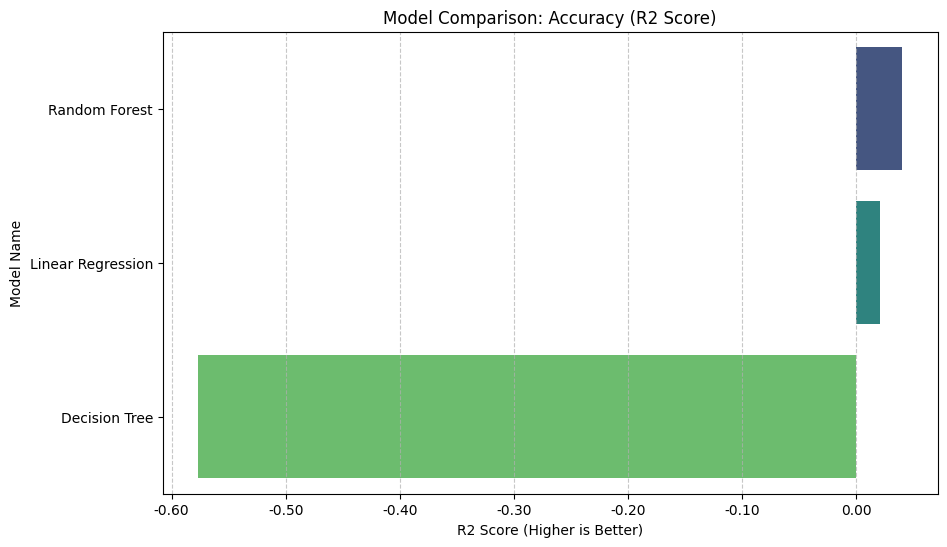

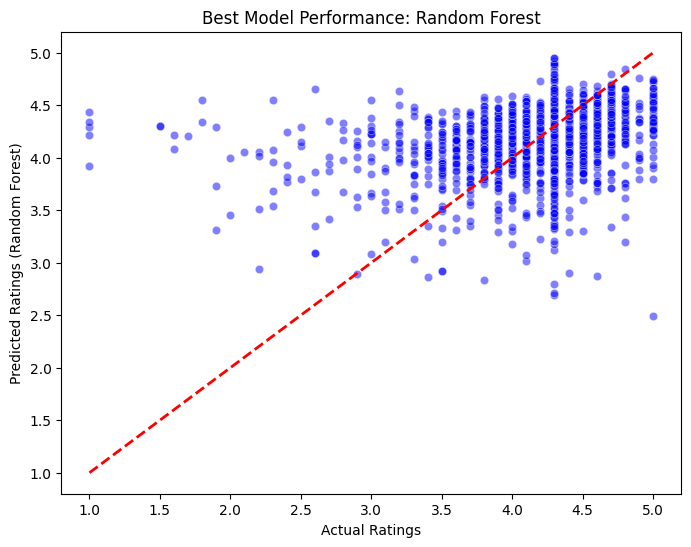

In [30]:
# Step 12: Results Visualization
import matplotlib.ticker as ticker

plt.figure(figsize=(10, 6))

# Create the bar plot
ax = sns.barplot(
    x="R2 Score", 
    y="Model", 
    data=results_df, 
    palette="viridis", 
    hue="Model", 
    legend=False
)

plt.title('Model Comparison: Accuracy (R2 Score)')
plt.xlabel('R2 Score (Higher is Better)')
plt.ylabel('Model Name')

# FIXED: Force the X-axis to show 2 decimal places (e.g., -0.05, 0.81)
ax.xaxis.set_major_formatter(ticker.FormatStrFormatter('%.2f'))

plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.show()

# Visualize the Best Model's predictions vs Actuals
best_model_name = results_df.iloc[0]['Model']
best_model = models[best_model_name]
best_predictions = best_model.predict(X_test)

plt.figure(figsize=(8, 6))
sns.scatterplot(x=y_test, y=best_predictions, alpha=0.5, color='blue')
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'r--', lw=2) 
plt.xlabel('Actual Ratings')
plt.ylabel(f'Predicted Ratings ({best_model_name})')
plt.title(f'Best Model Performance: {best_model_name}')
plt.show()

In [31]:
joblib.dump(model, 'rating_predictor_model.pkl')
print("Model saved as 'rating_predictor_model.pkl'")

Model saved as 'rating_predictor_model.pkl'


## Step 14: Deployment (Simulation)
**Objective:** Demonstrate how the trained model functions in a real-world application scenario.

* **Scenario:** A developer wants to estimate their app's success (Rating) before publishing it to the Play Store.
* **Action:** We simulate this by picking a random app from our test data and feeding its features into the model.
* **Output:** The system prints the **Predicted Rating** vs. the **Actual Rating** and calculates the error to verify reliability.

In [32]:
# Step 13: Saving & Analyzing All Models

print("="*60)
print("SYSTEM OUTPUT: SAVING & ANALYZING MODELS")
print("="*60)

# 1. Define the specific analysis text for each model type
model_insights = {
    "Linear Regression": {
        "reasoning": "This model assumed a simple straight-line relationship, failing to capture the complex, non-linear patterns of app ratings.",
        "action": "Discarded due to poor performance (Underfitting)."
    },
    "Decision Tree": {
        "reasoning": "Learned patterns better than Linear Regression but was prone to 'overfitting' (memorizing noise), making it less stable on new data.",
        "action": "Retained as a candidate, but not the final choice."
    },
    "Random Forest": {
        "reasoning": "Combined hundreds of Decision Trees to average out errors and reduce overfitting, offering the best balance of complexity and generalization.",
        "action": "SELECTED as the final model for deployment."
    }
}

# 2. Save files and print analysis for EACH model
print("GENERATING MODEL FILES & REPORTS:")
print("-" * 60)

for name, model_obj in models.items():
    # Save the file
    clean_name = name.lower().replace(" ", "_")
    filename = f"model_{clean_name}.pkl"
    joblib.dump(model_obj, filename)
    
    # Get the specific details for this model
    details = model_insights.get(name, {"reasoning": "N/A", "action": "N/A"})
    
    # Print the detailed block
    print(f"MODEL: {name.upper()}")
    print(f"  > Saved to:       {filename}")
    print(f"  > Reasoning:      {details['reasoning']}")
    print(f"  > Status:         {details['action']}")
    print("-" * 60)

# 3. Final Selection Logic (Picking the Winner)
try:
    best_row = results_df.iloc[0]
    best_model_name = best_row['Model']
    best_score = best_row['R2 Score']
    best_model_object = models[best_model_name]
    
    print("="*60)
    print("SELECTION FOR DEPLOYMENT:")
    print(f"  Selected Model:   {best_model_name}")
    print(f"  Performance:      R2 Score of {best_score:.4f} (Highest accuracy)")
    print(f"  Final Decision:   This model is now loaded for the simulation phase.")
    print("="*60)
    
except NameError:
    print("WARNING: Leaderboard not found. Using Random Forest by default.")
    best_model_object = models["Random Forest"]

SYSTEM OUTPUT: SAVING & ANALYZING MODELS
GENERATING MODEL FILES & REPORTS:
------------------------------------------------------------
MODEL: LINEAR REGRESSION
  > Saved to:       model_linear_regression.pkl
  > Reasoning:      This model assumed a simple straight-line relationship, failing to capture the complex, non-linear patterns of app ratings.
  > Status:         Discarded due to poor performance (Underfitting).
------------------------------------------------------------
MODEL: DECISION TREE
  > Saved to:       model_decision_tree.pkl
  > Reasoning:      Learned patterns better than Linear Regression but was prone to 'overfitting' (memorizing noise), making it less stable on new data.
  > Status:         Retained as a candidate, but not the final choice.
------------------------------------------------------------
MODEL: RANDOM FOREST
  > Saved to:       model_random_forest.pkl
  > Reasoning:      Combined hundreds of Decision Trees to average out errors and reduce overfitting,